In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io
from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping
from typing import List, Optional

In [ ]:
pd.set_option("display.max_colwidth", None)
from keras.layers import LSTM, GRU, SimpleRNN
from IPython.display import Markdown
def bold(string):
    display(Markdown("**" + string + "**"))
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Data Loading And Preprocessing

In [ ]:
try:
    df_ = pd.read_excel('/content/drive/MyDrive/Dataset/Global_Dataset.xlsx', usecols=['DESCRIPTION','SEVERITY'])
    df = df_.copy()
except Exception as e:
    print(f"An error occurred: {e}")

<Axes: ylabel='count'>

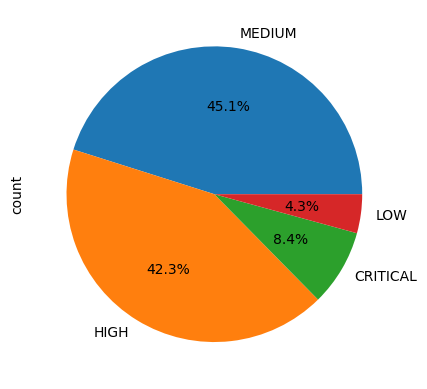

In [ ]:
df.head(17)
df = df.dropna()
df["SEVERITY"].value_counts().plot(kind="pie", autopct="%.1f%%")

In [ ]:
import io

def bold(text):
    print(f"\033[1m{text}\033[0m")

def print_stats(data):
    bold("#" * 50 + " SHAPE " + "#" * 50)
    print(f"ROWS: {data.shape[0]}")
    print(f"COLS: {data.shape[1]}")

    bold("#" * 50 + " TYPES " + "#" * 50)
    print(data.dtypes)

    bold("#" * 50 + " MISSING VALUES " + "#" * 50)
    print(data.isnull().sum())

    bold("#" * 50 + " DUPLICATED VALUES " + "#" * 50)
    print(f"NUMBER OF DUPLICATED VALUES: {data.duplicated().sum()}")

    bold("#" * 50 + " MEMORY USAGE " + "#" * 50)
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print(f"Memory Usage: {info}")


In [ ]:
print_stats(df)


################################################## SHAPE ##################################################
ROWS: 169480
COLS: 2
################################################## TYPES ##################################################
SEVERITY       object
DESCRIPTION    object
dtype: object
################################################## MISSING VALUES ##################################################
SEVERITY       0
DESCRIPTION    0
dtype: int64
################################################## DUPLICATED VALUES ##################################################
NUMBER OF DUPLICATED VALUES: 7737
################################################## MEMORY USAGE ##################################################
Memory Usage: 3.9+ MB


In [ ]:
df = df.dropna()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df[df["SEVERITY"] != 'None']


<Axes: xlabel='SEVERITY'>

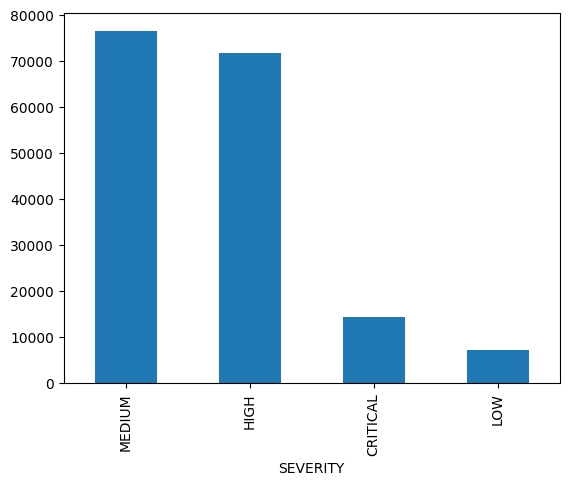

In [ ]:
df["SEVERITY"].value_counts().plot(kind="bar")

In [ ]:
smart_words = "/content/drive/MyDrive/helping_materials/SmartStoplist.txt"
smart_stoplist = []
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [ ]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
def clean(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

In [ ]:
df["CLEAN"] = df["DESCRIPTION"].apply(clean)


In [ ]:
le = LabelEncoder().fit(df["SEVERITY"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["LABELS"] = df["SEVERITY"].apply(lambda x: le_nm[x])
ndf = df.drop(["DESCRIPTION", "SEVERITY"], axis=1)


In [ ]:
def print_classes(le):
    print(f"Unique Classes: {le.classes_}")

In [ ]:
print_classes(le)

Unique Classes: ['CRITICAL' 'HIGH' 'LOW' 'MEDIUM']


In [ ]:
ndf.head()


,CLEAN,LABELS
0,ip_inputc bsdderived tcpip implementation remote attacker denial service crash hang crafted packet,3
1,buffer overflow nfs mountd root access remote attacker linux system,1
2,execute command root buffer overflow tooltalk database server rpcttdbserverd,1
3,mime buffer overflow email client solaris mailtool outlook,3
4,arbitrary command execution imap buffer overflow authenticate command,1


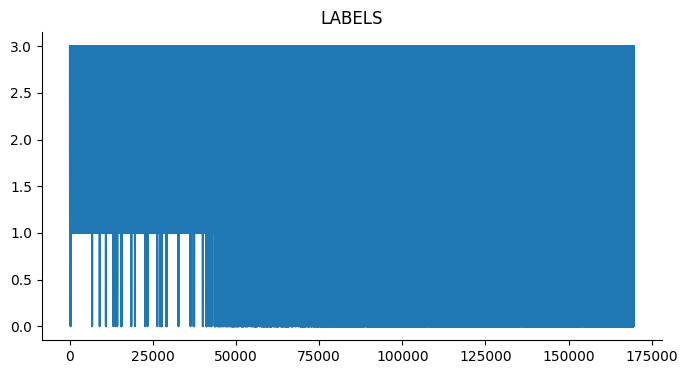

In [ ]:
from matplotlib import pyplot as plt
df['LABELS'].plot(kind='line', figsize=(8, 4), title='LABELS')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
X = ndf["CLEAN"]
y = ndf["LABELS"]

In [ ]:
print(set(y))

{0, 1, 2, 3}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
tokenizer = Tokenizer(num_words=400000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ")
tokenizer.fit_on_texts(X)

In [ ]:
word_index = tokenizer.word_index
len(word_index)
maxlen = 70

In [ ]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [ ]:
input_dim = len(tokenizer.word_index) + 1
input_dim

141133

# Experimentation

In [ ]:
print(set(y_train))

{0, 1, 2, 3}


              precision    recall  f1-score   support

    CRITICAL       0.81      0.00      0.01      2813
        HIGH       0.64      0.72      0.68     14348
         LOW       0.00      0.00      0.00      1443
      MEDIUM       0.66      0.77      0.71     15292

    accuracy                           0.65     33896
   macro avg       0.53      0.37      0.35     33896
weighted avg       0.64      0.65      0.61     33896



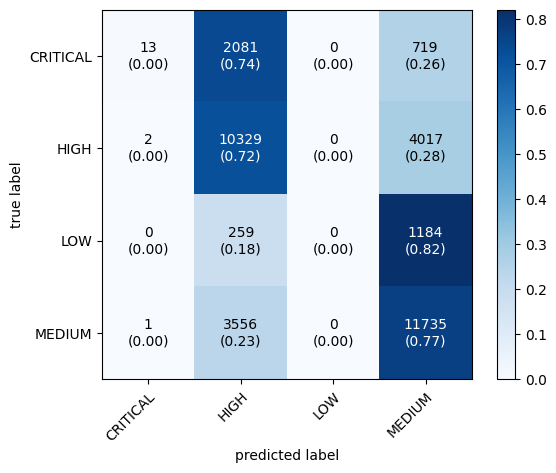

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=le.classes_))
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.show()

              precision    recall  f1-score   support

    CRITICAL       0.70      0.44      0.54      2813
        HIGH       0.71      0.80      0.75     14348
         LOW       0.67      0.31      0.43      1443
      MEDIUM       0.77      0.77      0.77     15292

    accuracy                           0.73     33896
   macro avg       0.71      0.58      0.62     33896
weighted avg       0.73      0.73      0.73     33896



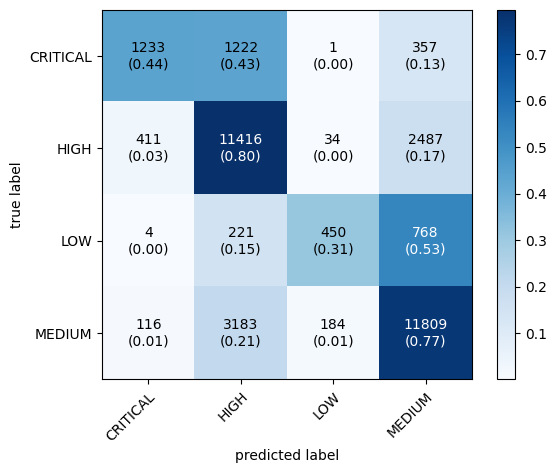

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=5, n_estimators=10)

# Train the model
rf.fit(X_train_tokenizer, y_train)

# Make predictions on training and test sets
rf_tfidf_pred_train = rf.predict(X_train_tokenizer)
rf_tfidf_pred_test = rf.predict(X_test_tokenizer)

# Print the classification report for the test set
print(classification_report(y_test, rf_tfidf_pred_test, target_names=le.classes_))

# Generate the confusion matrix
rf_tfidf_cm = confusion_matrix(y_test, rf_tfidf_pred_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=rf_tfidf_cm, show_absolute=True, show_normed=True,
                                colorbar=True, class_names=le.classes_)
plt.show()

              precision    recall  f1-score   support

    CRITICAL       0.24      0.25      0.24        53
        HIGH       0.31      0.31      0.31        61
         LOW       0.29      0.23      0.26        43
      MEDIUM       0.27      0.30      0.28        43

    accuracy                           0.28       200
   macro avg       0.27      0.27      0.27       200
weighted avg       0.28      0.28      0.27       200



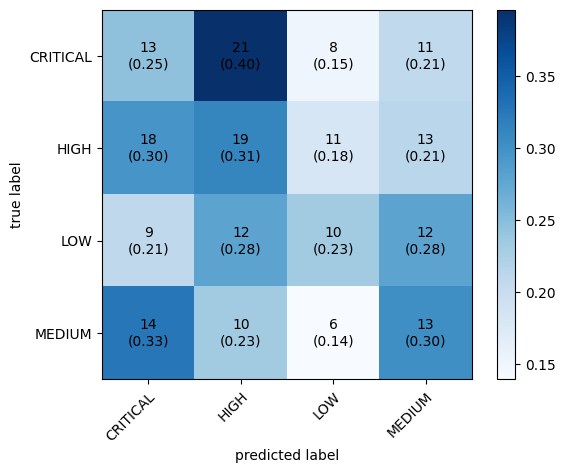

In [ ]:
from sklearn.svm import SVC


# Initialize the SVM classifier with a linear kernel
svm = SVC(kernel='linear', random_state=50, probability=True)

# Train the SVM model
svm.fit(X_train_tokenizer, y_train)

# Make predictions on the training and test sets
svm_pred_train = svm.predict(X_train_tokenizer)
svm_pred_test = svm.predict(X_test_tokenizer)

# Print the classification report for the test set
print(classification_report(y_test, svm_pred_test, target_names=le.classes_))

# Generate the confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=svm_cm, show_absolute=True, show_normed=True,
                                colorbar=True, class_names=le.classes_)
plt.show()
